 # AI Community @ Семинар № 5
 ## Уменьшение размерности с PCA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy import linalg as sla
from sklearn import decomposition
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style='white')

### SVD-разложение

Пусть $A$ — квадратная матрица. Тогда:
$$ A = U \Sigma V^T $$
называется SVD-разложением матрицы $A$ (singular value decomposition).  
$\Sigma$ — диагональная матрица, ее значения отсортированы по убыванию и называются сингулярными значениями.  
$U$, $V$ — самосопряженные ($U U^T = E$).

SVD-разложение:  
[Wiki](https://en.wikipedia.org/wiki/Singular-value_decomposition)  
[MIT](http://web.mit.edu/be.400/www/SVD/Singular_Value_Decomposition.htm)

**Полезные ссылки:**  
Собственные вектора и собственные значения:  
[Eigenvectors and Eigenvalues: Explained visually](http://setosa.io/ev/eigenvectors-and-eigenvalues/)  
[Wiki](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors)  
[Очень хороший ответ на CrossValidated](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues)

### PCA - Principal Component Analysis, Метод главных компонент

**Полезные ссылки:**  
[Курс Penn State University](https://onlinecourses.science.psu.edu/stat505/node/49)  
[PCA: Explained visually](http://setosa.io/ev/principal-component-analysis/)  
[One more PCA tutorial](http://sebastianraschka.com/Articles/2014_pca_step_by_step.html)

Нагенерим точек из гауссианы:

In [2]:
np.random.seed(42)

n_points = 300

skewed_cov = [[0.1, 0.2],
              [0.2, 2]]

uniform_cov = [[1, 0],
               [0, 1]]

X = np.random.multivariate_normal(mean=[1., 1.],
                                  cov=skewed_cov,
                                  size=n_points)

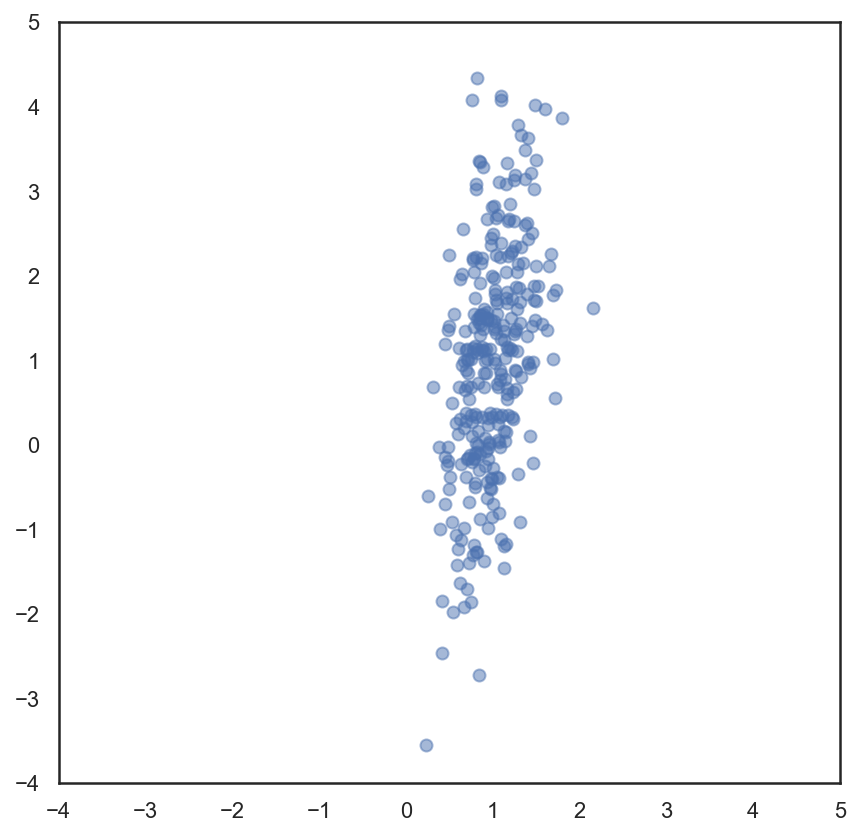

In [3]:
plt.figure(figsize=(7, 7))

plt.xlim(-4, 5)
plt.ylim(-4, 5)

plt.scatter(X[:, 0], X[:, 1], alpha=0.5);

In [4]:
cov_matrix = np.cov(X.T)

In [5]:
cov_matrix

array([[0.09503722, 0.19703108],
       [0.19703108, 1.91691368]])

Применим `SVD-разложение`:

In [6]:
U, S, V = sla.svd(cov_matrix)

In [7]:
S

array([1.93797851, 0.07397239])

Посмотрим на матрицу собственных векторов:

In [8]:
U

array([[ 0.1063054 ,  0.99433353],
       [ 0.99433353, -0.1063054 ]])

In [9]:
new_basis = np.diag(S) @ U

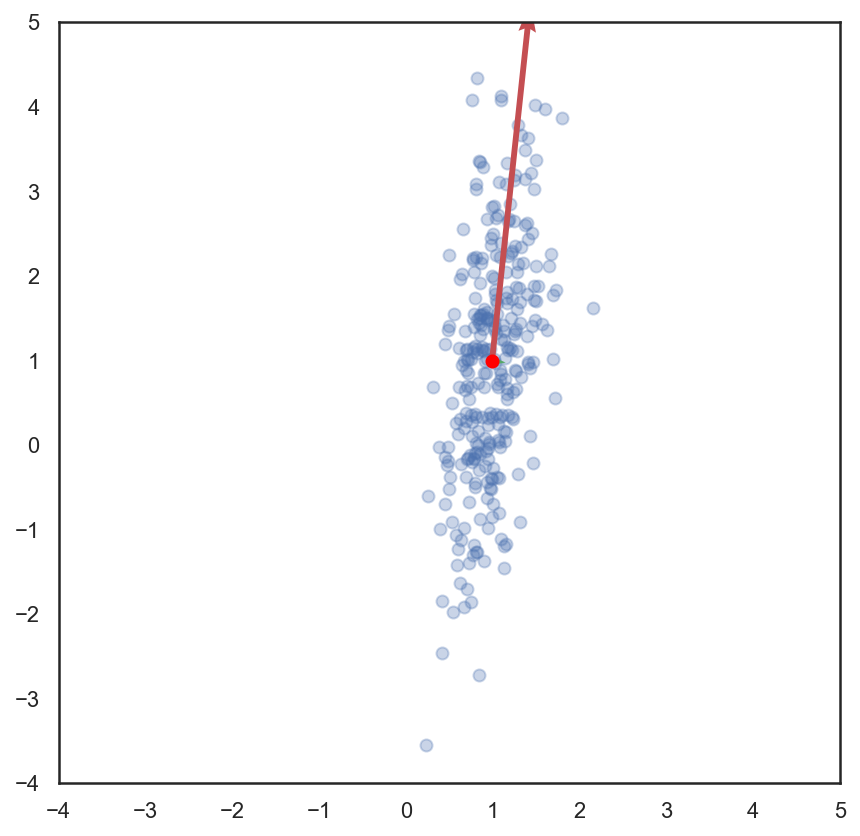

In [10]:
plt.figure(figsize=(7, 7))

plt.xlim(-4, 5)
plt.ylim(-4, 5)

plt.scatter(X[:, 0], X[:, 1], alpha=0.3);
plt.quiver(X.mean(axis=0)[0], X.mean(axis=0)[1],
           5 * new_basis[:, 0], 5 * new_basis[:, 1], color=['r','g'], scale=21)
plt.scatter(X.mean(axis=0)[0], X.mean(axis=0)[1], color='red');

In [11]:
U_reduced = U[:, 0][:, None]

In [12]:
X_transformed = X @ U_reduced @ U_reduced.T

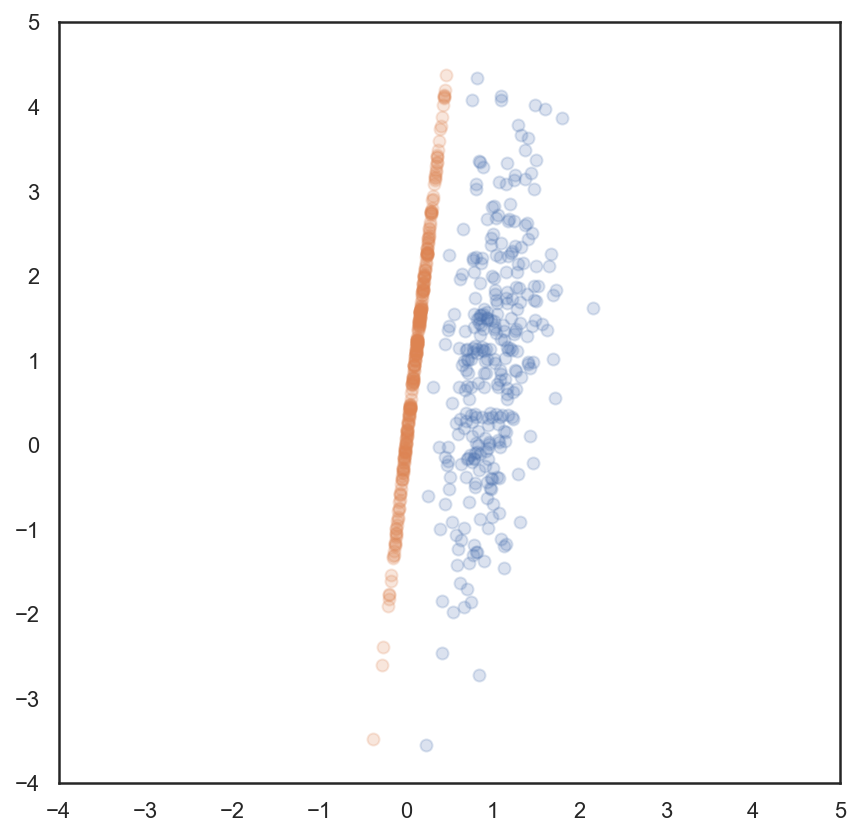

In [14]:
plt.figure(figsize=(7, 7))

plt.xlim(-4, 5)
plt.ylim(-4, 5)

plt.scatter(X[:, 0], X[:, 1], alpha=0.2);
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], alpha=0.2);

### PCA помогает классификации

Исследуем [Iris Dataset](https://archive.ics.uci.edu/ml/datasets/iris) из `sklearn`.

In [15]:
# Загрузим данные из sklearn
iris = datasets.load_iris()
X = iris.data
y = iris.target

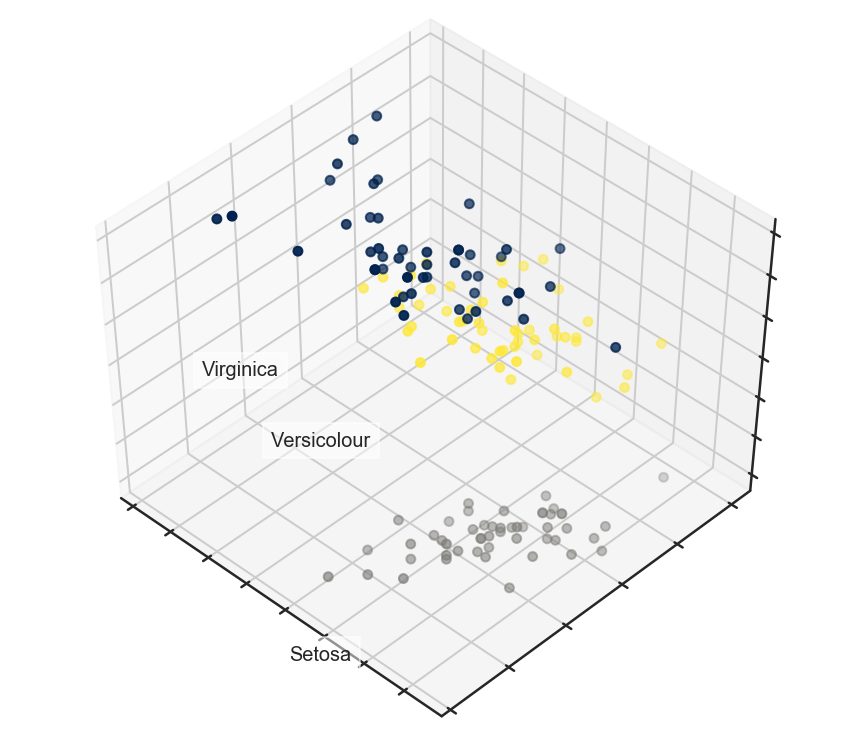

In [16]:
# Нарисуем данные в 3D
fig = plt.figure(1, figsize=(6, 5))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()

for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:
    ax.text3D(X[y == label, 0].mean(),
              X[y == label, 1].mean() + 1.5,
              X[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
    
# Поменяем порядок цветов меток, чтобы они соответствовали правильному
y_clr = np.choose(y, [1, 2, 0]).astype(np.float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_clr, cmap=plt.cm.cividis)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([]);

Предскажем тип цветка по его параметрам с помощью неглубокого дерева решений.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=41)

clf = DecisionTreeClassifier(max_depth=2, random_state=41)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, preds.argmax(axis=1))))

Accuracy: 0.91111


Применим PCA для визуализации:

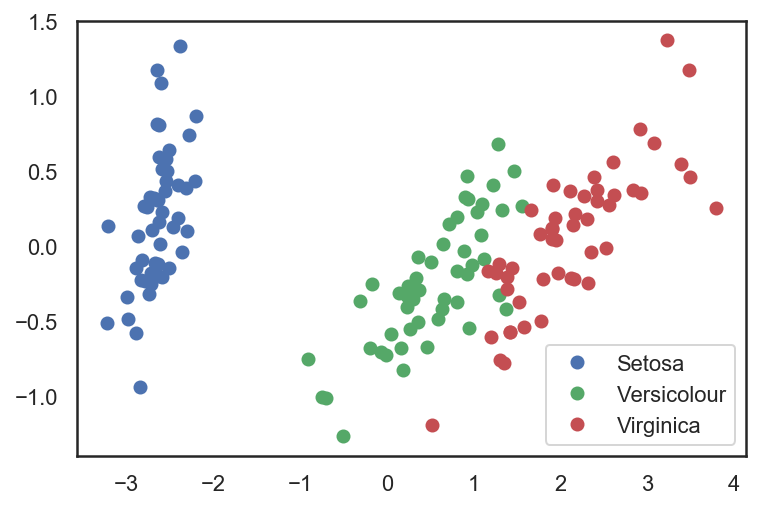

In [18]:
pca = decomposition.PCA(n_components=2)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], 'bo', label='Setosa')
plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], 'go', label='Versicolour')
plt.plot(X_pca[y == 2, 0], X_pca[y == 2, 1], 'ro', label='Virginica')
plt.legend(loc=0);

Обучим классификатор на измененных данных:

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=41)

clf = DecisionTreeClassifier(max_depth=2, random_state=41)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, preds.argmax(axis=1))))

Accuracy: 0.97778


### PCA помогает визуализации

Теперь поработаем с уже знакомым набором данных [MNIST](http://yann.lecun.com/exdb/mnist/).

In [20]:
digits = datasets.load_digits()
X = digits.data
y = digits.target

Для начала, посмотрим на данные:

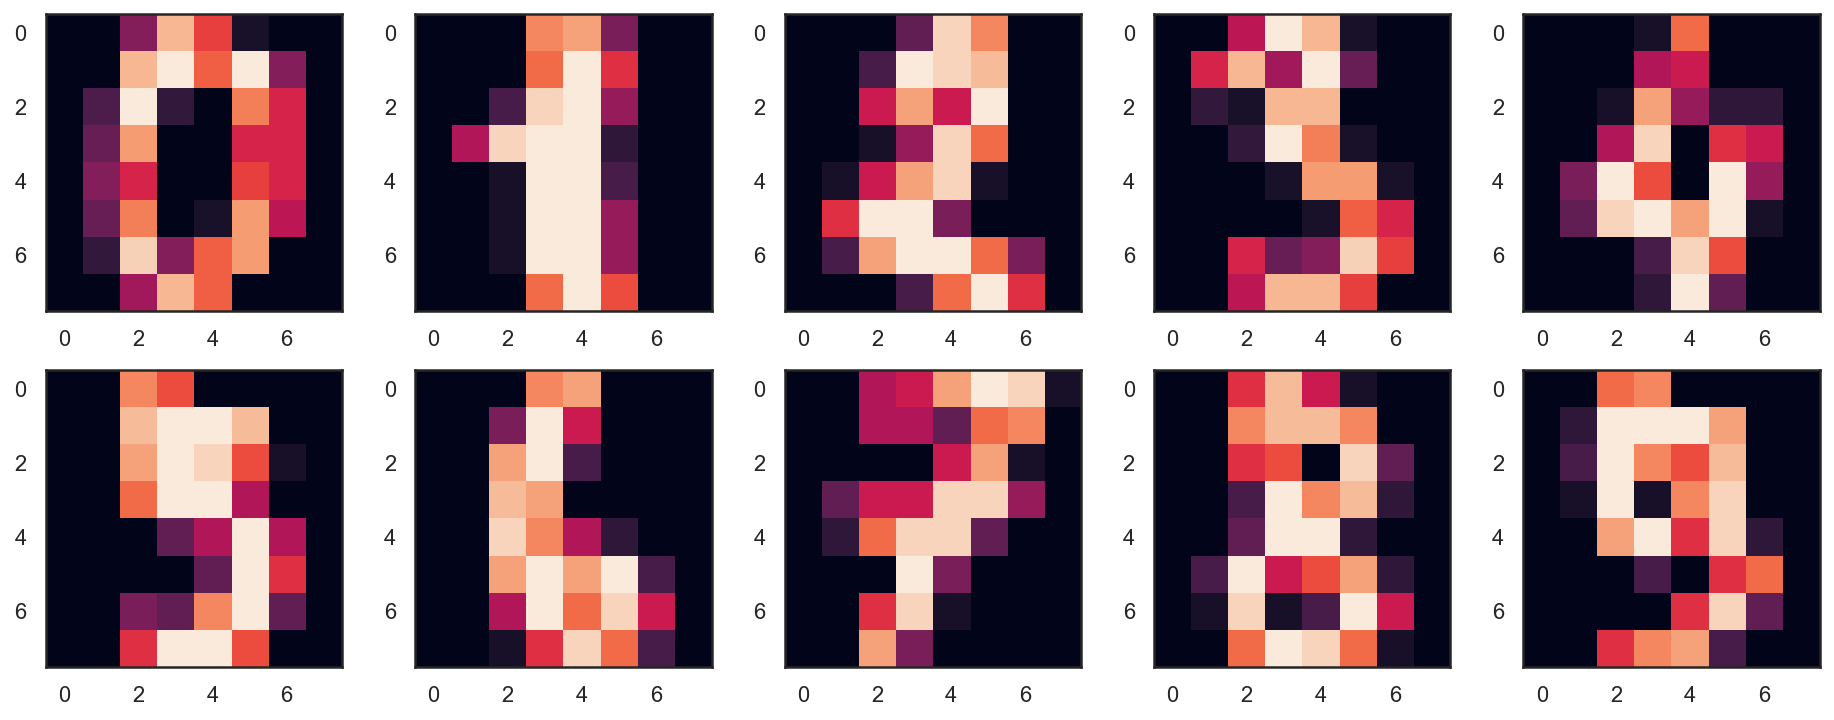

In [21]:
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i,:].reshape([8,8]));

Каждый пиксель - это признак, поэтому размерность наших данных - 64.  
Уменьшим размерность до 2 и посмотрим, что получится.

Projecting 64D data to 2D


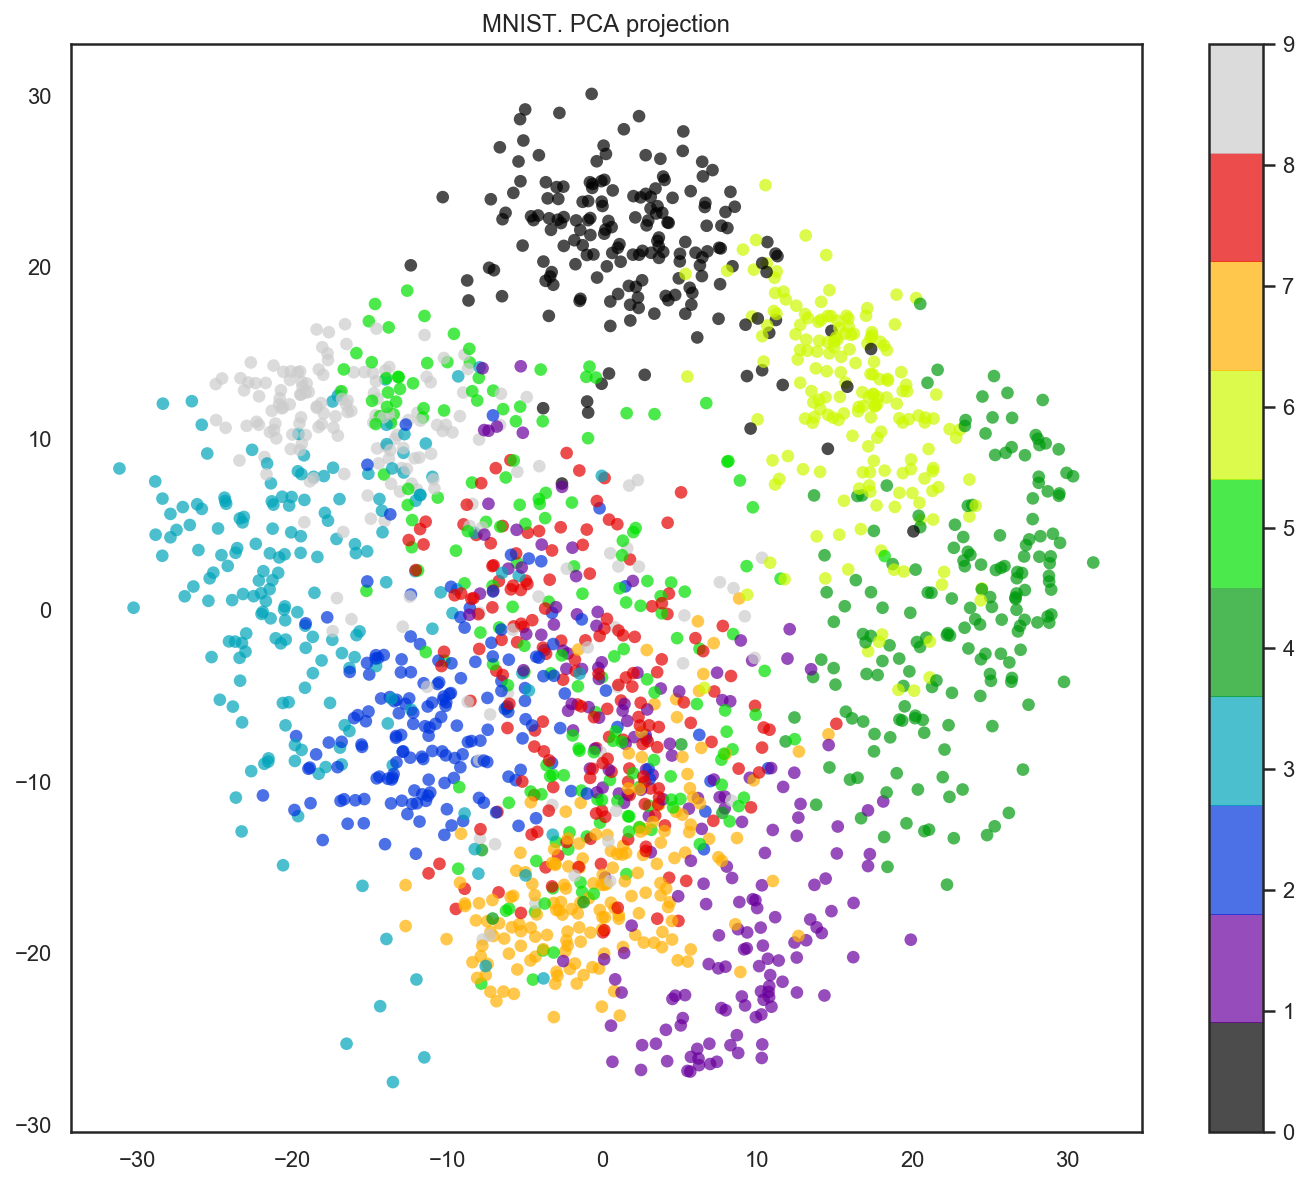

In [22]:
pca = decomposition.PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print('Projecting {}D data to 2D'.format(X.shape[1]))

plt.figure(figsize=(12, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. PCA projection');